In [1]:
import os
import subprocess
def module(*args):        
    if isinstance(args[0], list):        
        args = args[0]        
    else:        
        args = list(args)        
    (output, error) = subprocess.Popen(['/usr/bin/modulecmd', 'python'] + args, stdout=subprocess.PIPE).communicate()
    exec(output)    
module('load', 'apps/java/jdk1.8.0_102/binary')    
os.environ['PYSPARK_PYTHON'] = os.environ['HOME'] + '/.conda/envs/jupyter-spark/bin/python'

In [2]:
#import findspark
#findspark.init()
import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("COM6012 Spark Intro") \
    .getOrCreate()

sc = spark.sparkContext

In [13]:
from pyspark.sql.functions import split, regexp_extract

from pyspark.sql.functions import from_unixtime, unix_timestamp, to_date, to_timestamp
from pyspark.sql.types import *
from pyspark.sql.functions import date_format
import pyspark.sql.functions as f
from pyspark.sql.functions import mean
import matplotlib.pyplot as plt

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.recommendation import ALSModel
from pyspark.sql import Row

from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT



%matplotlib inline

## Question 1. Log Mining

### Preprocessing of  Data

In [3]:
logFile=spark.read.text("Data/NASA_access_log_Jul95.gz").cache()

In [4]:
# parsing our logFile into dataframe with 6 columns
df = logFile.select(regexp_extract('value', r'^([^\s]+\s)', 1).alias('host'),
                          regexp_extract('value', r'^.*\[(\d\d/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]', 1).alias('timestamp'),
                          regexp_extract('value', r'^.*"\w+\s+([^\s]+)\s+HTTP.*"', 1).alias('path'),
                          regexp_extract('value', r'^.*"\s+([^\s]+)', 1).cast('integer').alias('code'),
                          regexp_extract('value', r'^.*\s+(\d+)$', 1).cast('integer').alias('bytes'),
                   regexp_extract('value', r'^.*\[(\d\d\/\w{3}\/\d{4}:\d{2}:\d{2}:\d{2})',1).alias('times'))

In [5]:
df.show(5,False)

+---------------------+--------------------------+-----------------------------------------------+----+-----+--------------------+
|host                 |timestamp                 |path                                           |code|bytes|times               |
+---------------------+--------------------------+-----------------------------------------------+----+-----+--------------------+
|199.72.81.55         |01/Jul/1995:00:00:01 -0400|/history/apollo/                               |200 |6245 |01/Jul/1995:00:00:01|
|unicomp6.unicomp.net |01/Jul/1995:00:00:06 -0400|/shuttle/countdown/                            |200 |3985 |01/Jul/1995:00:00:06|
|199.120.110.21       |01/Jul/1995:00:00:09 -0400|/shuttle/missions/sts-73/mission-sts-73.html   |200 |4085 |01/Jul/1995:00:00:09|
|burger.letters.com   |01/Jul/1995:00:00:11 -0400|/shuttle/countdown/liftoff.html                |304 |0    |01/Jul/1995:00:00:11|
|199.120.110.21       |01/Jul/1995:00:00:11 -0400|/shuttle/missions/sts-73/sts-73-p

In [6]:
# Data cleaning from null values
df = df.na.fill({'bytes': 0})
df = df.na.drop()

### A. Find out the average number of requests on each of the seven days in a week (i.e., Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, and Sunday) during July 1995. You need to report SEVEN numbers, one for each day of the week.  


In [7]:
res = df.select('*',to_timestamp(df.times, "dd/MMM/yyyy:HH:mm:ss").alias('full date')).drop('times')
weekdays = res.select(to_date('full date').alias('date'), date_format('full date', 'E').alias('Weekday'))

In [10]:
week = weekdays.groupBy('date').count().select('count', date_format('date', 'E').alias('Weekday'))

In [11]:
average_per_day = week.groupBy('Weekday').agg(mean('count').alias('average'))
sorted_average = average_per_day.sort(unix_timestamp("Weekday", "E"))

In [12]:
weekday_average = (sorted_average
                .select('Weekday', 'average')
                .rdd
                .map(lambda r: (r[0], r[1]))
                .collect())
weekday_average = weekday_average[4:]+weekday_average[:4]
week, average = zip(*weekday_average)

In [13]:
sorted_average.show()

+-------+-------+
|Weekday|average|
+-------+-------+
|    Thu|90859.0|
|    Fri|65771.5|
|    Sat|46095.0|
|    Sun|45647.5|
|    Mon|75421.0|
|    Tue|69460.0|
|    Wed|79674.5|
+-------+-------+



### B. Visualise the results in A above as a figure (e.g., bar graph or pie chart) and discuss your observations (e.g., any trend, contrast, something expected, unexpected or interesting) using 1 to 3 sentences. To plot on HPC, you need to activate your environment and install  matplotlib via conda install -c conda-forge matplotlib.

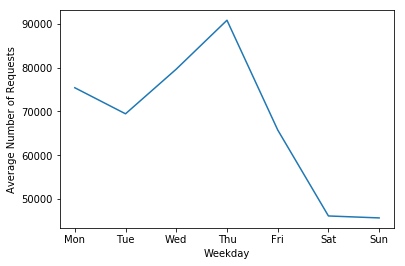

In [14]:
plt.xlabel('Weekday')
plt.ylabel('Average Number of Requests')
plt.plot(week, average)
plt.show() 

### C. Find out the top 20 most requested .gif images. Report the file name and number of requests for each of these 20 images. 

In [15]:
gif_request = res.filter(res.path.contains(".gif" or ".GIF")).cache()
top_gif = gif_request.groupBy('path').count().sort('count', ascending=False)

In [16]:
top_gif.show(20,False)

+---------------------------------------------------+------+
|path                                               |count |
+---------------------------------------------------+------+
|/images/NASA-logosmall.gif                         |111087|
|/images/KSC-logosmall.gif                          |89530 |
|/images/MOSAIC-logosmall.gif                       |60300 |
|/images/USA-logosmall.gif                          |59845 |
|/images/WORLD-logosmall.gif                        |59325 |
|/images/ksclogo-medium.gif                         |58616 |
|/images/launch-logo.gif                            |40841 |
|/images/ksclogosmall.gif                           |33555 |
|/history/apollo/images/apollo-logo1.gif            |31052 |
|/shuttle/countdown/count.gif                       |22189 |
|/shuttle/countdown/count70.gif                     |20921 |
|/images/launchmedium.gif                           |20788 |
|/shuttle/missions/sts-71/sts-71-patch-small.gif    |19832 |
|/shuttle/missions/sts-7

### D. Visualise the results in C above as a figure (e.g., bar graph or pie chart) and discuss your observations (e.g., anything interesting) using 1 to 3 sentences.

In [17]:
gifs = (top_gif.select('path', 'count').rdd.map(lambda r: (r[0], r[1])).collect())
gif, requests = zip(*gifs)

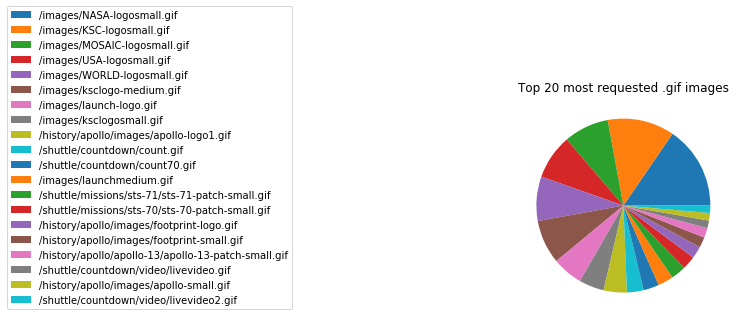

In [18]:
patches, texts = plt.pie(requests[:20])

plt.legend(patches, gif[:20], loc='lower right', bbox_to_anchor=(-1, 0),
           fontsize=10)
plt.title('Top 20 most requested .gif images')
plt.show() 

## Question 2. Movie Recommendation  

In [4]:
ratings = spark.read.csv("Data/ml-20m/ratings.csv", header=True).cache()

In [5]:
ratings = ratings.withColumn("userId", ratings["userId"].cast(IntegerType()))
ratings = ratings.withColumn("movieId", ratings["movieId"].cast(IntegerType()))
ratings = ratings.withColumn("rating", ratings["rating"].cast(DoubleType()))
ratings = ratings.withColumn("timestamp", ratings["timestamp"].cast(IntegerType()))

In [6]:
ratings.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
|     1|     47|   3.5|1112484727|
|     1|     50|   3.5|1112484580|
|     1|    112|   3.5|1094785740|
|     1|    151|   4.0|1094785734|
|     1|    223|   4.0|1112485573|
|     1|    253|   4.0|1112484940|
|     1|    260|   4.0|1112484826|
|     1|    293|   4.0|1112484703|
|     1|    296|   4.0|1112484767|
|     1|    318|   4.0|1112484798|
|     1|    337|   3.5|1094785709|
|     1|    367|   3.5|1112485980|
|     1|    541|   4.0|1112484603|
|     1|    589|   3.5|1112485557|
|     1|    593|   3.5|1112484661|
|     1|    653|   3.0|1094785691|
|     1|    919|   3.5|1094785621|
+------+-------+------+----------+
only showing top 20 rows



### A. Perform a five-fold cross validation of ALS-based recommendation on the rating data ratings.csv. Study two versions of ALS: one with the ALS setting in Lab 3 notebook with “drop” as the coldStartStartegy, and another different setting decided by you. For each of the five splits, report the Root Mean Square Error (RMSE) and Mean Absolute Error (MAE) for the two versions of ALS. Then compute and report the mean and standard deviation (std) of RMSE and MAE. Put all results (these numbers for RMSEs and MAEs in a Table in the report. Hint: check out the RegressionEvaluator API. 

In [23]:
splits = ratings.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed = 10)
als1 = ALS(maxIter=10, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
als2 = ALS(maxIter=5, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
evaluator1 = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
evaluator2 = RegressionEvaluator(metricName="mae", labelCol="rating",predictionCol="prediction")

# store rmse, mae and model for the different splits
rmse1 = []
mae1 = []
rmse2 = []
mae2 = []
mdl1 = []
mdl2 = []


for test in splits:

    training = ratings.subtract(test)

    model1 = als1.fit(training)
    predictions1 = model1.transform(test)
    rmse1.append(evaluator1.evaluate(predictions1))
    mae1.append(evaluator2.evaluate(predictions1))
    mdl1.append(model1)

    model2 = als2.fit(training)
    predictions2 = model2.transform(test)
    rmse2.append(evaluator1.evaluate(predictions2))
    mae2.append(evaluator2.evaluate(predictions2))
    mdl2.append(model2)

In [24]:
import numpy as np
print('Model 1')
print('RMSE:',rmse1)
print('RMSE Mean:', np.mean(rmse1))
print('RMSE Standard Deviation:', np.std(rmse1))
print('MAE:',mae1)
print('MAE Mean:', np.mean(mae1))
print('MAE Standard Deviation:', np.std(mae1))

print('Model 2')
print('RMSE:',rmse2)
print('RMSE Mean:', np.mean(rmse2))
print('RMSE Standard Deviation:', np.std(rmse2))
print('MAE:',mae2)
print('MAE Mean:', np.mean(mae2))
print('MAE Standard Deviation:', np.std(mae2))

Model 1
RMSE: [0.8054755856425707, 0.8050334387627959, 0.8105421582542981, 0.8115185456129608, 0.8115634772279994]
RMSE Mean: 0.8088266411
RMSE Standard Deviation: 0.00294270547812
MAE: [0.6249901276813115, 0.6245698170044005, 0.6328820886181125, 0.6334942963959526, 0.633614613882222]
MAE Mean: 0.629910188716
MAE Standard Deviation: 0.00419826996047
Model 2
RMSE: [0.8253819162338106, 0.825218808972137, 0.8246893919423764, 0.8259099684198886, 0.8260052014914236]
RMSE Mean: 0.825441057412
RMSE Standard Deviation: 0.00048083866356
MAE: [0.6489031741714635, 0.6488484710951736, 0.6483965330927223, 0.6493120844599589, 0.6494646147972614]
MAE Mean: 0.648984975523
MAE Standard Deviation: 0.000376468724792


### C. After ALS, each movie is modelled with some factors. Use k-means with k=20 to cluster the movie factors (hint: see itemFactors in ALS API, id=movieid in this problem) learned with the ALS setting in Lab 3 notebook in A for each of the five splits. For each of the five split, use genome-scores.csv to find the top five tags for each of the top three largest clusters (i.e., 15 tags in total for each split) and report the names of these top tags using genome-tags.csv. Hint: For each cluster, sum up tag scores for all movies in it; find the largest five scores and their indexes; go to genome-tags to find their names.

In [25]:
scores = spark.read.csv("Data/ml-20m/genome-scores.csv", header=True).cache()

In [26]:
tags = spark.read.csv("Data/ml-20m/genome-tags.csv", header=True).cache()

In [27]:
scores = scores.withColumn("tagId", scores["tagId"].cast(IntegerType()))
scores = scores.withColumn("movieId", scores["movieId"].cast(IntegerType()))
scores = scores.withColumn("relevance", scores["relevance"].cast(DoubleType()))

In [28]:
tags = tags.withColumn("tagId", tags["tagId"].cast(IntegerType()))

In [29]:
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

kmeans = KMeans(k=20, seed=1)

best_tags1 = []
best_tags2 = []
for i in range(5):
    dfItemFactors=mdl1[i].itemFactors
    data = dfItemFactors.select("id", to_vector("features").alias("features"))
    model = kmeans.fit(data)
    transformed = model.transform(data)

    clusters = transformed.groupBy('prediction').count().sort('count', ascending=False).limit(3)
    clusters1 = [int(row.prediction) for row in clusters.collect()]
    
    for j in clusters1:
        allmovies1 = transformed.filter(transformed.prediction == j)
        movies_tags = scores.join(allmovies1, [scores.movieId == allmovies1.id])
        total = movies_tags.groupBy('tagId').agg(f.sum('relevance').alias('sum')).sort('sum', ascending=False).limit(5)
        best_tags1.append(total.join(tags, ['tagId']))
    
    dfItemFactors=mdl2[i].itemFactors
    data = dfItemFactors.select("id", to_vector("features").alias("features"))
    model = kmeans.fit(data)
    transformed = model.transform(data)

    clusters = transformed.groupBy('prediction').count().sort('count', ascending=False).limit(3)
    clusters2 = [int(row.prediction) for row in clusters.collect()]

    
    for j in clusters2:
        allmovies2 = transformed.filter(transformed.prediction == j)
        movies_tags = scores.join(allmovies2, [scores.movieId == allmovies2.id])
        total = movies_tags.groupBy('tagId').agg(f.sum('relevance').alias('sum')).sort('sum', ascending=False).limit(5)
        best_tags2.append(total.join(tags, ['tagId']))

In [33]:
for i in range(5):
    print('Model 1, Split',i+1)
    for j in range(3):
        print('Cluster', j+1)
        best_tags1[(3*i)+j].show()
    print('Model 2, Split',i+1)
    for j in range(3):
        print('Cluster', j+1)
        best_tags2[(3*i)+j].show()

Model 1, Split 1
Cluster 1
+-----+-----------------+------------+
|tagId|              sum|         tag|
+-----+-----------------+------------+
|  445|558.1044999999999|        good|
|  468|522.5029999999999|great ending|
|  646|575.5952499999997|      mentor|
|  742|        656.81375|    original|
|  971|523.5417500000001|       story|
+-----+-----------------+------------+

Cluster 2
+-----+-----------------+-----------------+
|tagId|              sum|              tag|
+-----+-----------------+-----------------+
|  452|          643.441|  good soundtrack|
|  468|         594.2085|     great ending|
|  742|811.8684999999996|         original|
|  936|612.9800000000002|social commentary|
|  972|646.4452499999994|     storytelling|
+-----+-----------------+-----------------+

Cluster 3
+-----+------------------+---------------+
|tagId|               sum|            tag|
+-----+------------------+---------------+
|  302|313.38199999999983|       dialogue|
|  452|294.08549999999997|good s

+-----+------------------+---------------+
|tagId|               sum|            tag|
+-----+------------------+---------------+
|  302|218.30449999999996|       dialogue|
|  452|200.76174999999995|good soundtrack|
|  468|218.40725000000003|   great ending|
|  646|226.78000000000003|         mentor|
|  742| 321.6562500000001|       original|
+-----+------------------+---------------+

Cluster 2
+-----+------------------+---------------+
|tagId|               sum|            tag|
+-----+------------------+---------------+
|  302|463.98624999999987|       dialogue|
|  452|464.59650000000005|good soundtrack|
|  468| 470.3392500000001|   great ending|
|  646| 450.1154999999999|         mentor|
|  742| 635.6487499999998|       original|
+-----+------------------+---------------+

Cluster 3
+-----+-----------------+------------+
|tagId|              sum|         tag|
+-----+-----------------+------------+
|  445|536.4554999999999|        good|
|  468|496.3189999999999|great ending|
|  646|56